# Facial Keypoint Dectection

## Detect the location of keypoints on face images

Excerpt from https://www.kaggle.com/c/facial-keypoints-detection

The objective of this task is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:

tracking faces in images and video
analysing facial expressions
detecting dysmorphic facial signs for medical diagnosis
biometrics / face recognition
Detecing facial keypoints is a very challenging problem.  Facial features vary greatly from one individual to another, and even for a single individual, there is a large amount of variation due to 3D pose, size, position, viewing angle, and illumination conditions. Computer vision research has come a long way in addressing these difficulties, but there remain many opportunities for improvement.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/mily/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Understanding data
Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

In [2]:
# Separate X_train and y_train from the training data. 
# X_train will contain the images.
# y_train will contain labels for corresponding to the images.

# X_train[i] will contain a flattened 96x96 image as a numpy array.
# y_train[i] will contain 30 labels: 15 pairs of x,y coordinates for the features mentioned above.

import os.path

np_loaded_data_file = "../data/train_data.npz"
if not os.path.isfile(np_loaded_data_file):
    print "reading data ..."
    try:
        df=pd.read_csv('../data/training.csv', sep=',')
    except:
        print "Download training.csv from kaggle website"
    input_train = df.values
    
    X_train = input_train[:, 30]
    y_train = input_train[:, 0:30]
    
    templist = []
    for i in range(X_train.shape[0]):
        templist.append([int(s) for s in X_train[i].split()])
    X_train = np.array(templist)
    
    X_train = X_train.astype(float)
    y_train = y_train.astype(float)
    np.savez(np_loaded_data_file, X_train=X_train, y_train=y_train)
else:
    print "training data %s exists. loading... " % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    X_train = npzfile['X_train']
    y_train = npzfile['y_train']


training data ../data/train_data.npz exists. loading... 


[[1237 5664  901 4280 2603]
 [6148  643 5883 1143 2208]
 [6228 3832 5392  237  164]
 [2824 6425 1128 1103   72]
 [6308 4805 1162 6480 2787]]


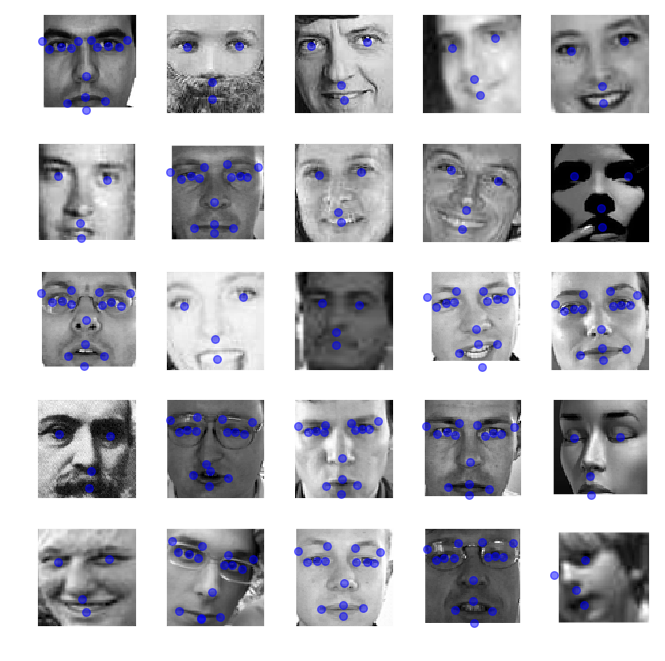

In [14]:
# print X_train.shape
# print y_train.shape

N_img_x = 5
N_img_y = 5
sel_idx = np.random.choice(X_train.shape[0], N_img_x * N_img_y, replace=False).reshape(N_img_x, N_img_y)
print sel_idx

plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
xx=15
yy=15
SS = 72
for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        i = sel_idx[n_x][n_y]
        a = X_train[i].reshape(96, 96)
        a = a[xx:(xx+SS), yy:(yy+SS)]
#         a = a[0:(84), 0:(84)]
        b = y_train[i]
        b_x = b[0::2] - xx
        b_y = b[1::2] - yy

        plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
        plt.imshow(a)
        plt.scatter(b_x, b_y, s=30, alpha=0.5, color='blue')
        plt.gca().axis('off')
plt.show()


In [4]:
# From the above pictures, we see that some of the features are missing.
print y_train[4096]

# The missing keypoints appear as nan in the coordinates.


[ 65.61309767  36.20282791  28.76248186  38.2312186           nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  45.32829767  68.32029767          nan          nan          nan
          nan          nan          nan  47.0187907   78.80070698]


In [7]:
# Next, we use the following piece of code to understand which features miss the most.

y_nan_check = np.isnan(y_train)

a = np.sum(y_nan_check, axis=1)
b = np.sum(y_nan_check, axis=0)

# full_feature_check = (a == 0)

print "number of images with atleast one missing feature = ", np.sum(np.logical_not((a == 0)))

feature_labels = "left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image"
feature_labels = feature_labels.split(",")

import pprint
print "Assuming _x and _y for a feature always go missing together, "

# pprint.pprint(dict(zip(feature_labels , b)))
print (dict(zip(feature_labels , b)))
pprint.pprint(dict(zip(feature_labels , range(len(feature_labels)))))

 number of images with atleast one missing feature =  4909
Assuming _x and _y for a feature always go missing together, 
{'left_eyebrow_outer_end_x': 4824, 'left_eyebrow_outer_end_y': 4824, 'mouth_center_bottom_lip_x': 33, 'left_eyebrow_inner_end_y': 4779, 'left_eyebrow_inner_end_x': 4779, 'right_eyebrow_outer_end_x': 4813, 'right_eyebrow_outer_end_y': 4813, 'mouth_left_corner_y': 4780, 'mouth_left_corner_x': 4780, 'left_eye_outer_corner_y': 4782, 'left_eye_outer_corner_x': 4782, 'left_eye_center_y': 10, 'left_eye_center_x': 10, 'mouth_right_corner_y': 4779, 'mouth_right_corner_x': 4779, 'mouth_center_bottom_lip_y': 33, 'right_eye_outer_corner_y': 4781, 'right_eye_outer_corner_x': 4781, 'right_eye_center_y': 13, 'right_eye_center_x': 13, 'right_eye_inner_corner_x': 4781, 'right_eye_inner_corner_y': 4781, 'right_eyebrow_inner_end_y': 4779, 'right_eyebrow_inner_end_x': 4779, 'mouth_center_top_lip_x': 4774, 'mouth_center_top_lip_y': 4774, 'left_eye_inner_corner_x': 4778, 'left_eye_inner_c

From the above images, 
1) Some of the keypoints are missing in training data.
2) The placement of the images are not accurate. For example, the nose tip feature is not always on the nose.

In [8]:
# remove mean from data
X_train = X_train - np.mean(X_train)

## Saving cleaned data
Here we save the data removing inconsistencied. The list feature_filter selects the features we want in the cleaned data set. If `feature_filter = [0, 1, 20, 21, 2, 3, 28, 29]`, only the images with left eye center, nose tip, right eye center and mouth center are saved.

If `feature_filter = range(30)`, only the images with all the features are saved. 

In [9]:
feature_filter = [0, 1, 20, 21, 2, 3, 28, 29]
# feature_filter = range(30)

img_filter = np.all((y_nan_check[:, feature_filter] == False), axis=1)


# Save good data
X_train_clean = X_train[img_filter]
y_train_clean = y_train[img_filter][:, feature_filter]

X_train_miss = X_train[np.logical_not(img_filter)]
y_train_miss = y_train[np.logical_not(img_filter)]


input_size = 96

X_train_clean = X_train_clean.reshape(-1, 1, input_size, input_size)
X_train_miss = X_train_miss.reshape(-1, 1, input_size, input_size)


print X_train_clean.shape, y_train_clean.shape
print X_train_miss.shape, y_train_miss.shape


num_good_images = X_train_clean.shape[0]

typical_batch_size = 128
num_val = int (np.ceil((0.2 * num_good_images) // typical_batch_size) * typical_batch_size )
print "num_val = ", num_val
num_train = X_train_clean.shape[0] - num_val



(7000, 1, 96, 96) (7000, 8)
(49, 1, 96, 96) (49, 30)
num_val =  1280


In [11]:
rand_idx = np.random.choice(num_good_images, num_good_images, replace=False)

X_train_clean_cv = X_train_clean[rand_idx[:num_train]] 
y_train_clean_cv = y_train_clean[rand_idx[:num_train]]


X_val_clean_cv = X_train_clean[rand_idx[num_train:]] 
y_val_clean_cv = y_train_clean[rand_idx[num_train:]]

print X_train_clean_cv.shape, y_train_clean_cv.shape
print X_val_clean_cv.shape, y_val_clean_cv.shape



(5720, 1, 96, 96) (5720, 8)
(1280, 1, 96, 96) (1280, 8)


In [12]:
np_loaded_data_file = "../data/train_data_cleaned_4feat.npz"
np.savez(np_loaded_data_file, 
         X_train_clean_cv=X_train_clean_cv, y_train_clean_cv=y_train_clean_cv, 
         X_val_clean_cv=X_val_clean_cv, y_val_clean_cv=y_val_clean_cv,
         feature_labels=feature_labels)

In [13]:
## Save good data to hd5 format

import h5py
f = h5py.File("../data/train_data_clean_4feat_full.hd5", "w")
f.create_dataset("data", data=X_train_clean_cv,  compression="gzip", compression_opts=4)
f.create_dataset("label", data=y_train_clean_cv,  compression="gzip", compression_opts=4)
f.close()


f = h5py.File("../data/test_data_clean_4feat_full.hd5", "w")
f.create_dataset("data", data=X_val_clean_cv,  compression="gzip", compression_opts=4)
f.create_dataset("label", data=y_val_clean_cv,  compression="gzip", compression_opts=4)
f.close()

In [10]:
# Create a small data set
# import h5py
# f = h5py.File("../data/train_data_clean_50.hd5", "w")
# f.create_dataset("data", data=X_train_clean_cv[0:50],  compression="gzip", compression_opts=4)
# f.create_dataset("label", data=y_train_clean_cv[0:50],  compression="gzip", compression_opts=4)
# f.close()


In [11]:
# import h5py
# f = h5py.File("../data/train_data_clean_500.hd5", "w")
# f.create_dataset("data", data=X_train_clean_cv[0:500],  compression="gzip", compression_opts=4)
# f.create_dataset("label", data=y_train_clean_cv[0:500],  compression="gzip", compression_opts=4)
# f.close()


In [12]:
# import h5py
# f = h5py.File("../data/train_data_clean_200.hd5", "w")
# f.create_dataset("data", data=X_train_clean_cv[0:200],  compression="gzip", compression_opts=4)
# f.create_dataset("label", data=y_train_clean_cv[0:200],  compression="gzip", compression_opts=4)
# f.close()